# Train, deploy and monitor a XGBoost regression model with the Amazon SageMaker and alert using AWS Lambda and Amazon SNS

Link: [https://github.com/aws-samples/amazon-sagemaker-xgboost-regression-model-monitor-and-alerting/tree/main](https://github.com/aws-samples/amazon-sagemaker-xgboost-regression-model-monitor-and-alerting/tree/main)

[Amazon SageMaker](https://aws.amazon.com/sagemaker/) is a fully managed machine learning service. With SageMaker, you have the option of using the built-in algorithms or you can bring your own algorithms and frameworks. One of the features offered by Amazon SageMaker is [Model Monitor](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor.html) which continuously monitors the quality of Amazon SageMaker machine learning models in production. With Model Monitor, you can set alerts that notify you when there are deviations from the specified baseline for the specified monitoring type. 

This notebook demonstrates how to use the SageMaker's [built-in XGBoost algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html) to train a regression model on the [California Housing dataset](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html), deploy it on a SageMaker inference endpoint and monitor using SageMaker Model Monitor.  Of the various monitoring types supported by the Model Monitor, we will demonstrate [Data Quality Monitor](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-data-quality.html) and [Model Quality Monitor](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-model-quality.html) in this notebook.  When you complete running through all the steps in this notebook, you will notice both Data Quality and Model Quality violations assuming you have not changed the data or the processing logic.  Finally, this notebook will provide an overview of the process involved in setting up alerting using [AWS Lambda](https://aws.amazon.com/lambda/) and [Amazon SNS](https://aws.amazon.com/sns) to send out e-mail or text based alerts.  A code sample for the Lambda function is also included.

With the Data Quality Monitor, you can detect data quality drift by tracking the difference between data that was used to train the models versus the data that is being presented to the model to score.

With the Model Quality Monitor, you can monitor model characteristics (such as MAE, MSE, RMSE, R2, precision, accuracy, recall and more) of your ML models in real time.  SageMaker Model monitor reports how well a ML model is predicting outcomes by comparing model prediction to ground truth data.

**Note:**

* This notebook should only be run from within a SageMaker notebook instance as it references SageMaker native APIs.
* At the time of writing this notebook, the most relevant latest version of the Jupyter notebook kernel for this notebook was `conda_python3` and this came built-in with SageMaker notebooks.
* This notebook uses CPU based instances for training.
* This notebook will create resources in the same AWS account and in the same region where this notebook is running.

**Table of Contents:**

1. [Complete prerequisites](#Complete%20prerequisites)

    1. [Check and configure access to the Internet](#Check%20and%20configure%20access%20to%20the%20Internet)

    2. [Check and upgrade required software versions](#Check%20and%20upgrade%20required%20software%20versions)
    
    3. [Check and configure security permissions](#Check%20and%20configure%20security%20permissions)

    4. [Organize imports](#Organize%20imports)
    
    5. [Create common objects](#Create%20common%20objects)

2. [Prepare the data](#Prepare%20the%20data)

    1. [Create the local directories](#Create%20the%20local%20directories)
    
    2. [Load the dataset and view the details](#Load%20the%20dataset%20and%20view%20the%20details)
    
    3. [(Optional) Visualize the dataset](#(Optional)%20Visualize%20the%20dataset)
    
    4. [Split the dataset into train, validate and test sets](#Split%20the%20dataset%20into%20train,%20validate%20and%20test%20sets)
    
    5. [Standardize the datasets](#Standardize%20the%20datasets)
    
    6. [Save the prepared datasets locally](#Save%20the%20prepared%20datasets%20locally)
    
    7. [Upload the prepared datasets to S3](#Upload%20the%20prepared%20datasets%20to%20S3)

3. [Perform training](#Perform%20training)

    1. [Set the training parameters](#Set%20the%20training%20parameters)
    
    2. [(Optional) Delete previous checkpoints](#(Optional)%20Delete%20previous%20checkpoints)
    
    3. [Run the training job](#Run%20the%20training%20job)

4. [Perform deployment](#Perform%20deployment)

    1. [Set the deployment parameters](#Set%20the%20deployment%20parameters)
    
    2. [Set the data capture parameters](#Set%20the%20data%20capture%20parameters)
    
    3. [(Optional) Delete previously deployed resources](#(Optional)%20Delete%20previously%20deployed%20resources)

    4. [Deploy the model](#Deploy%20the%20model)

5. [Create monitoring baselines](#Create%20monitoring%20baselines)

    1. [Data Quality Monitor](#Data%20Quality%20Monitor)
    
        1. [Prepare the dataset for baselining](#Prepare%20the%20dataset%20for%20baselining_DQ)
    
        2. [Create the Data Quality Monitor](#Create%20the%20Data%20Quality%20Monitor_DQ)

        3. [Generate the baseline](#Generate%20the%20baseline_DQ)
        
        4. [Display the generated baseline](#Display%20the%20generated%20baseline_DQ)

    2. [Model Quality Monitor](#Model%20Quality%20Monitor)
    
        1. [Prepare the dataset for baselining](#Prepare%20the%20dataset%20for%20baselining_MQ)
    
        2. [Create the Model Quality Monitor](#Create%20the%20Model%20Quality%20Monitor_MQ)
        
        3. [Generate the baseline](#Generate%20the%20baseline_MQ)
        
        4. [Display the generated baseline](#Display%20the%20generated%20baseline_MQ)
        
6. [Schedule monitoring jobs](#Schedule%20monitoring%20jobs)

    1. [Create Data Quality monitoring schedule](#Create%20Data%20Quality%20monitoring%20schedule)
    
    2. [Create Model Quality monitoring schedule](#Create%20Model%20Quality%20monitoring%20schedule)
    
    3. [Print schedule details](#Print%20schedule%20details)
    
    4. [Start/stop/delete schedules](#Start/stop/delete%20schedules)

7. [Send traffic to endpoint](#Send%20traffic%20to%20endpoint)

8. [Analyze monitoring executions](#Analyze%20monitoring%20executions)

    1. [View monitoring executions](#View%20monitoring%20executions)
    
    2. [View latest constraint violations](#View%20latest%20constraint%20violations)

9. [Generate alerts](#Generate%20alerts)

10. [Cleanup](#Cleanup)


##  1. Complete prerequisites <a id='Complete%20prerequisites'></a>

Check and complete the prerequisites.

###  A. Check and configure access to the Internet <a id='Check%20and%20configure%20access%20to%20the%20Internet'></a>

This notebook requires outbound access to the Internet to download the required software updates.  You can either provide direct Internet access (default) or provide Internet access through a VPC.  For more information on this, refer [here](https://docs.aws.amazon.com/sagemaker/latest/dg/appendix-notebook-and-internet-access.html).

### B. Check and upgrade required software versions  <a id='Check%20and%20upgrade%20required%20software%20versions'></a>

This notebook requires:
* [SageMaker Python SDK version 2.x](https://sagemaker.readthedocs.io/en/stable/v2.html)
* [Python 3.6.x](https://www.python.org/downloads/release/python-360/)
* [Boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html)

Note: If you get 'module not found' errors in the following cell, then uncomment the appropriate installation commands and install the modules.  Also, uncomment and run the kernel shutdown command.  When the kernel comes back, comment out the installation and kernel shutdown commands and run the following cell.  Now, you should not see any errors.

In [1]:
import boto3
import IPython
import sagemaker
import sys

"""
Last tested versions:
SageMaker Python SDK version : 2.41.0
Python version : 3.6.13 | packaged by conda-forge | (default, Feb 19 2021, 05:36:01) 
[GCC 9.3.0]
Boto3 version : 1.17.77
"""

# Install/upgrade the Sagemaker SDK and Boto3
#!{sys.executable} -m pip install -U sagemaker boto3
#IPython.Application.instance().kernel.do_shutdown(True)

# Get the current installed version of Sagemaker SDK, Python and Boto3
print('SageMaker Python SDK version : {}'.format(sagemaker.__version__))
print('Python version : {}'.format(sys.version))
print('Boto3 version : {}'.format(boto3.__version__))

/home/nick/venv/lib/python3.13/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[03/14/25 16:51:48] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=658858;file:///home/nick/venv/lib/python3.13/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=130681;file:///home/nick/venv/lib/python3.13/site-packages/botocore/credentials.py#1352\1352]8;;\

sagemaker.config INFO - Not applying SDK defaults from location: /home/nick/.config/kdedefaults/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/nick/.config/sagemaker/config.yaml
SageMaker Python SDK version : 2.240.0
Python version : 3.13.2 (main, Feb  5 2025, 08:05:21) [GCC 14.2.1 20250128]
Boto3 version : 1.37.7


###  C. Check and configure security permissions <a id='Check%20and%20configure%20security%20permissions'></a>

This notebook uses the IAM role attached to the underlying notebook instance.  This role should have the following permissions,

1. Full access to the S3 bucket that will be used to store training and output data.
2. Full access to launch training instances.
3. Full access to deploy models.
4. Full access to launch monitoring instances and schedules.
5. Access to write to CloudWatch logs and metrics.

To view the name of this role, run the following cell.

In [4]:
sagemaker_role = "arn:aws:iam::146868985163:role/SageMaker-ExecutionRole"

###  D. Organize imports <a id='Organize%20imports'></a>

Organize all the library and module imports for later use.

In [6]:
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn.model_selection
from sklearn.preprocessing import StandardScaler
from sagemaker.inputs import TrainingInput
from sagemaker.model_monitor import CronExpressionGenerator
from sagemaker.model_monitor import DataCaptureConfig
from sagemaker.model_monitor import DefaultModelMonitor
from sagemaker.model_monitor import ModelQualityMonitor
from sagemaker.model_monitor.dataset_format import DatasetFormat
from sagemaker.model_monitor.model_monitoring import EndpointInput
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer
import datetime
import random

[03/14/25 16:53:54] INFO     Failed to extract font properties from                            ]8;id=776121;file:///home/nick/venv/lib/python3.13/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=337681;file:///home/nick/venv/lib/python3.13/site-packages/matplotlib/font_manager.py#1107\1107]8;;\
                             /usr/share/fonts/adobe-source-sans/SourceSansVariable-Roman.otf:                      
                             Can not load face (SFNT font table missing; error code 0x8e)                          

                    INFO     Failed to extract font properties from                            ]8;id=188431;file:///home/nick/venv/lib/python3.13/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=130048;file:///home/nick/venv/lib/python3.13/site-packages/matplotlib/font_manager.py#1107\1107]8;;\
                             /usr/share/fonts/noto/NotoColorEmoji.ttf: Can not load face                           
                             (unknown file format; error code 0x2)                                                 

                    INFO     Failed to extract font properties from                            ]8;id=367010;file:///home/nick/venv/lib/python3.13/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=809273;file:///home/nick/venv/lib/python3.13/site-packages/matplotlib/font_manager.py#1107\1107]8;;\
                             /usr/share/fonts/adobe-source-code-pro/SourceCodeVF-Italic.otf:                       
                             Can not load face (SFNT font table missing; error code 0x8e)                          

                    INFO     Failed to extract font properties from                            ]8;id=817696;file:///home/nick/venv/lib/python3.13/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=539208;file:///home/nick/venv/lib/python3.13/site-packages/matplotlib/font_manager.py#1107\1107]8;;\
                             /usr/share/fonts/adobe-source-code-pro/SourceCodeVF-Upright.otf:                      
                             Can not load face (SFNT font table missing; error code 0x8e)                          

                    INFO     Failed to extract font properties from                            ]8;id=506184;file:///home/nick/venv/lib/python3.13/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=588692;file:///home/nick/venv/lib/python3.13/site-packages/matplotlib/font_manager.py#1107\1107]8;;\
                             /usr/share/fonts/adobe-source-sans/SourceSansVariable-Italic.otf:                     
                             Can not load face (SFNT font table missing; error code 0x8e)                          

                    INFO     Failed to extract font properties from                            ]8;id=775148;file:///home/nick/venv/lib/python3.13/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=958186;file:///home/nick/venv/lib/python3.13/site-packages/matplotlib/font_manager.py#1107\1107]8;;\
                             /usr/share/fonts/adobe-source-sans/SourceSans3VF-Italic.otf: Can                      
                             not load face (SFNT font table missing; error code 0x8e)                              

                    INFO     Failed to extract font properties from                            ]8;id=460932;file:///home/nick/venv/lib/python3.13/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=612803;file:///home/nick/venv/lib/python3.13/site-packages/matplotlib/font_manager.py#1107\1107]8;;\
                             /usr/share/fonts/adobe-source-sans/SourceSans3VF-Upright.otf: Can                     
                             not load face (SFNT font table missing; error code 0x8e)                              

[03/14/25 16:53:55] INFO     Failed to extract font properties from                            ]8;id=367715;file:///home/nick/venv/lib/python3.13/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=410293;file:///home/nick/venv/lib/python3.13/site-packages/matplotlib/font_manager.py#1107\1107]8;;\
                             /usr/share/fonts/cantarell/Cantarell-VF.otf: Can not load face                        
                             (SFNT font table missing; error code 0x8e)                                            

                    INFO     generated new fontManager                                         ]8;id=590960;file:///home/nick/venv/lib/python3.13/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=893285;file:///home/nick/venv/lib/python3.13/site-packages/matplotlib/font_manager.py#1639\1639]8;;\

###  E. Create common objects <a id='Create%20common%20objects'></a>

Create common objects to be used in future steps in this notebook.

In [7]:
# Specify the S3 bucket name
s3_bucket = 'adgu-model-monitor-bucket'

# Create the S3 Boto3 resource
s3_resource = boto3.resource('s3')
s3_bucket_resource = s3_resource.Bucket(s3_bucket)

# Create the SageMaker Boto3 client
sm_client = boto3.client('sagemaker')

# Base name to be used to create resources
nb_name = 'sm-xgboost-ca-housing-monitor-alert'

# Names of various resources
train_job_name = 'train-{}'.format(nb_name)
model_name = 'model-{}'.format(nb_name)
endpoint_name = 'endpt-{}'.format(nb_name)
dq_base_job_name = 'dq-{}'.format(nb_name)
mq_base_job_name = 'mq-{}'.format(nb_name)
dq_baseline_job_name_prefix = 'dq-bsl-job-{}'.format(nb_name)
mq_baseline_job_name_prefix = 'mq-bsl-job-{}'.format(nb_name)
dq_mon_schedule_name = 'dq-mon-sch-{}'.format(nb_name)
mq_mon_schedule_name = 'mq-mon-sch-{}'.format(nb_name)

# Names of local sub-directories in the notebook file system
data_dir = os.path.join(os.getcwd(), 'data/{}'.format(nb_name))
train_dir = os.path.join(os.getcwd(), 'data/{}/train'.format(nb_name))
val_dir = os.path.join(os.getcwd(), 'data/{}/validate'.format(nb_name))
test_dir = os.path.join(os.getcwd(), 'data/{}/test'.format(nb_name))
ground_truth_dir = os.path.join(os.getcwd(), 'data/{}/ground-truth'.format(nb_name))

# Location of the datasets file in the notebook file system
dataset_csv_file = os.path.join(os.getcwd(), 'datasets/california_housing.csv')

# Sub-folder names in S3
train_dir_s3_prefix = '{}/data/train'.format(nb_name)
val_dir_s3_prefix = '{}/data/validate'.format(nb_name)
test_dir_s3_prefix = '{}/data/test'.format(nb_name)
ground_truth_dir_s3_prefix = '{}/data/ground-truth'.format(nb_name)

# Location in S3 where the model checkpoint will be stored
model_checkpoint_s3_path = 's3://{}/{}/checkpoint/'.format(s3_bucket, nb_name)

# Location in S3 where the trained model will be stored
model_output_s3_path = 's3://{}/{}/output/'.format(s3_bucket, nb_name)

# Location in S3 that will contain all model monitor related files
model_monitor_s3_path = 's3://{}/{}/model-monitor'.format(s3_bucket, nb_name)

# Location in S3 where the data captured from the endpoint will be stored.
# Do not add a '/' at the end of the path here; it will be automatically added by the endpoint. If you add
# a '/' at the end, then the monitoring schedule will not be able to find the data capture files and your
# schedule will fail even if files are present in that S3 location.
data_capture_output_s3_path = '{}/data-capture'.format(model_monitor_s3_path)

# Location in S3 where the results from the baseline job will be stored
dq_baseline_job_output_s3_path = '{}/data-quality/baseline/'.format(model_monitor_s3_path)

# Location in S3 where the results from the baseline job will be stored
mq_baseline_job_output_s3_path = '{}/model-quality/baseline/'.format(model_monitor_s3_path)

# Location in S3 where the results from the monitoring job will be stored
# Do not add a '/' at the end of the path here
dq_mon_schedule_output_s3_path = '{}/data-quality/monitoring'.format(model_monitor_s3_path)

# Location in S3 where the results from the monitoring job will be stored
# Do not add a '/' at the end of the path here
mq_mon_schedule_output_s3_path = '{}/model-quality/monitoring'.format(model_monitor_s3_path)

# Set the inference id prefix to consistently use it when invoking the endpoint
# at various steps in this notebook
inference_id_prefix = 'FromNotebook_'

[03/14/25 16:53:58] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=845019;file:///home/nick/venv/lib/python3.13/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=493925;file:///home/nick/venv/lib/python3.13/site-packages/botocore/credentials.py#1352\1352]8;;\

## 2. Prepare the data <a id='Prepare%20the%20data'></a>

The [California Housing dataset](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html) consists of 20,640 observations on housing prices with 9 economic covariates.  These covariates are,

* MedianHouseValue
* MedianIncome
* HousingMedianAge
* TotalRooms
* TotalBedrooms
* Population
* Households
* Latitude
* Longitude

This dataset has been downloaded to the local `datasets` directory and modified as a CSV file with the feature names in the first row.  This will be used in this notebook.

The following steps will help with preparing the datasets for training, validation and testing.

### A) Create the local directories <a id='Create%20the%20local%20directories'></a>

Create the directories in the local system where the dataset will be copied to and processed.

In [8]:
# Create the local directories
os.makedirs(data_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(ground_truth_dir, exist_ok=True)

### B) Load the dataset and view the details <a id='Load%20the%20dataset%20and%20view%20the%20details'></a>

Check if the CSV file exists in the `datasets` directory and load it into a Pandas DataFrame.  Finally, print the details of the dataset.

In [11]:
# Check if the dataset file exists and proceed
if os.path.exists(dataset_csv_file):
    print('Dataset CSV file \'{}\' exists.'.format(dataset_csv_file))
    # Load the data into a Pandas DataFrame
    pd_data_frame = pd.read_csv(dataset_csv_file)
    # Print the first 5 records
    #print(pd_data_frame.head(5))
    # Describe the dataset
    print(pd_data_frame.describe())
else:
    print('Dataset CSV file \'{}\' does not exist.'.format(dataset_csv_file))

Dataset CSV file '/home/nick/bb/awsmlassoc/Labs/8.1/datasets/california_housing.csv' exists.
       median_house_value  median_income  housing_median_age   total_rooms  \
count        20640.000000   20640.000000        20640.000000  20640.000000   
mean        206855.816909       3.870671           28.639486   2635.763081   
std         115395.615874       1.899822           12.585558   2181.615252   
min          14999.000000       0.499900            1.000000      2.000000   
25%         119600.000000       2.563400           18.000000   1447.750000   
50%         179700.000000       3.534800           29.000000   2127.000000   
75%         264725.000000       4.743250           37.000000   3148.000000   
max         500001.000000      15.000100           52.000000  39320.000000   

       total_bedrooms    population    households      latitude     longitude  
count    20640.000000  20640.000000  20640.000000  20640.000000  20640.000000  
mean       537.898014   1425.476744    499.5

### C) (Optional) Visualize the dataset <a id='(Optional)%20Visualize%20the%20dataset'></a>

Display the distributions in the dataset.

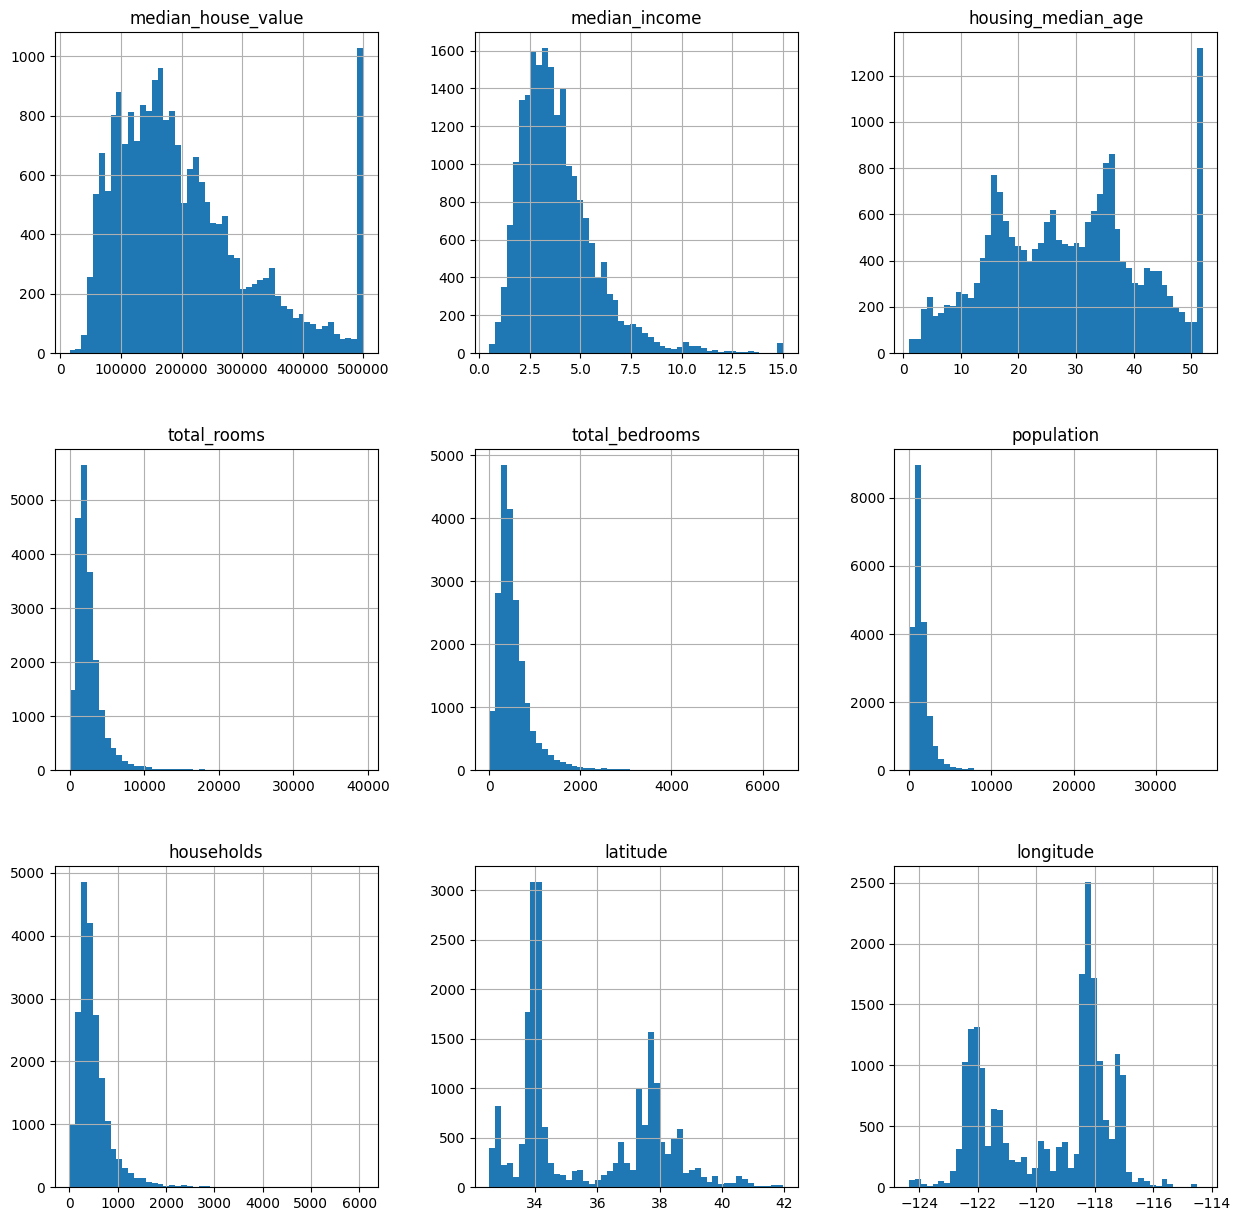

In [12]:
pd_data_frame.hist(bins=50, figsize=(15,15))
plt.show()

### D) Split the dataset into train, validate and test sets <a id='Split%20the%20dataset%20into%20train,%20validate%20and%20test%20sets'></a>

Split the dataset into train, validate and test sets after shuffling.  Split further into x and y sets.

In [13]:
# Split into train and test datasets after shuffling
train, test = sklearn.model_selection.train_test_split(pd_data_frame, test_size=0.2,
                                                       random_state=35, shuffle=True)
# Split the train dataset further into train and validation datasets after shuffling
train, val = sklearn.model_selection.train_test_split(train, test_size=0.1,
                                                      random_state=25, shuffle=True)

# Define functions to get x and y columns
def get_x(df):
    return df[['median_income','housing_median_age','total_rooms','total_bedrooms',
                 'population','households','latitude','longitude']]
def get_y(df):
    return df[['median_house_value']]

# Load the x and y columns for train, validation and test datasets
x_train = get_x(train)
y_train = get_y(train)
x_val = get_x(val)
y_val = get_y(val)
x_test = get_x(test)
y_test = get_y(test)

# Summarize the datasets
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (14860, 8)
y_train shape: (14860, 1)
x_val shape: (1652, 8)
y_val shape: (1652, 1)
x_test shape: (4128, 8)
y_test shape: (4128, 1)


### E) Standardize the datasets <a id='Standardize%20the%20datasets'></a>

* Standardize the x columns of the train dataset using the `fit_transform()` function of `StandardScaler`.
* Standardize the x columns of the validate and test datasets using the `transform()` function of `StandardScaler`.

In [14]:
# Standardize the dataset
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

### F) Save the prepared datasets locally <a id='Save%20the%20prepared%20datasets%20locally'></a>

Save the prepared train, validate and test datasets to local directories.  Prior to saving, concatenate x and y columns as needed.  Create the directories if they don't exist.

In [15]:
# Define function to prepend header and create the specified new file
def create_file_with_header(src_file_full_path, tgt_file_full_path, header):
    with open(src_file_full_path, 'rt') as src_file, open(tgt_file_full_path, 'wt') as tgt_file:
        tgt_file.write(header + '\n')
        for src_line in src_file:
            tgt_file.write(src_line)

# Save the prepared dataset (in numpy format) to the local directories as csv files
np.savetxt(os.path.join(train_dir, 'train.csv'),
           np.concatenate((y_train.to_numpy(), x_train), axis=1), delimiter=',')
np.savetxt(os.path.join(train_dir, 'train_x.csv'), x_train)
create_file_with_header(os.path.join(train_dir, 'train_x.csv'),
                        os.path.join(train_dir, 'train_x_with_header.csv'),
                        'median_income,housing_median_age,total_rooms,total_bedrooms,population,households,latitude,longitude')
np.savetxt(os.path.join(train_dir, 'train_y.csv'), y_train.to_numpy())

np.savetxt(os.path.join(val_dir, 'validate.csv'),
           np.concatenate((y_val.to_numpy(), x_val), axis=1), delimiter=',')
np.savetxt(os.path.join(val_dir, 'validate_x.csv'), x_val)
np.savetxt(os.path.join(val_dir, 'validate_y.csv'), y_val.to_numpy())

np.savetxt(os.path.join(test_dir, 'test.csv'),
           np.concatenate((y_test.to_numpy(), x_test), axis=1), delimiter=',')
np.savetxt(os.path.join(test_dir, 'test_x.csv'), x_test)
np.savetxt(os.path.join(test_dir, 'test_y.csv'), y_test.to_numpy())

### G) Upload the prepared datasets to S3 <a id='Upload%20the%20prepared%20datasets%20to%20S3'></a>

Upload the datasets from the local directories to appropriate sub-directories in the specified S3 bucket.

In [17]:
# Upload the data to S3
train_dir_s3_path = sagemaker.Session().upload_data(path='./data/{}/train/'.format(nb_name),
                                                          bucket=s3_bucket,
                                                          key_prefix=train_dir_s3_prefix)
val_dir_s3_path = sagemaker.Session().upload_data(path='./data/{}/validate/'.format(nb_name),
                                                        bucket=s3_bucket,
                                                        key_prefix=val_dir_s3_prefix)
test_dir_s3_path = sagemaker.Session().upload_data(path='./data/{}/test/'.format(nb_name),
                                                         bucket=s3_bucket,
                                                         key_prefix=test_dir_s3_prefix)

# Capture the S3 locations for the uploaded datasets
train_s3_path = '{}/train.csv'.format(train_dir_s3_path)
train_x_s3_path = '{}/train_x.csv'.format(train_dir_s3_path)
train_y_s3_path = '{}/train_y.csv'.format(train_dir_s3_path)
train_x_with_header_s3_path = '{}/train_x_with_header.csv'.format(train_dir_s3_path)
val_s3_path = '{}/validate.csv'.format(val_dir_s3_path)
val_x_s3_path = '{}/validate_x.csv'.format(val_dir_s3_path)
val_y_s3_path = '{}/validate_y.csv'.format(val_dir_s3_path)
test_s3_path = '{}/test.csv'.format(test_dir_s3_path)
test_x_s3_path = '{}/test_x.csv'.format(test_dir_s3_path)
test_y_s3_path = '{}/test_y.csv'.format(test_dir_s3_path)

##  3. Perform training <a id='Perform%20training'></a>

In this step, SageMaker's [built-in XGBoost algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html) is used to train a regression model on the [California Housing dataset](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html).

Note: Although you can perform validation along with training, we will not do that here.  Instead, we will run through the validation dataset on the deployed model to create a baseline for the Model Monitor.

### A) Set the training parameters <a id='Set%20the%20training%20parameters'></a>

1. Inputs - S3 location of the training data.
2. Hyperparameters.
3. Training instance details:

    1. Instance count
    
    2. Instance type
    
    3. The max run time of the training job
    
    4. (Optional) Use Spot instances.  For more info, refer [here](https://docs.aws.amazon.com/sagemaker/latest/dg/model-managed-spot-training.html).
    
    5. (Optional) The max wait for Spot instances, if using Spot.  This should be larger than the max run time.
    
4. Base job name
5. Appropriate local and S3 directories that will be used by the training job.

In [18]:
# Set the input data input along with their content types
train_input = TrainingInput(train_s3_path, content_type='text/csv')
inputs = {'train':train_input}

# Set the hyperparameters
hyperparameters = {
        'objective':'reg:squarederror',
        'max_depth':'6',
        'eta':'0.3',
        'alpha':'3',
        'colsample_bytree':'0.7',
        'num_round':'100'}

# Set the instance count, instance type, volume size, options to use Spot instances and other parameters
train_instance_count = 1
train_instance_type = 'ml.m5.xlarge'
train_instance_volume_size_in_gb = 5
#use_spot_instances = True
#spot_max_wait_time_in_seconds = 5400
use_spot_instances = False
spot_max_wait_time_in_seconds = None
max_run_time_in_seconds = 3600
region_name = sagemaker.Session().boto_region_name
algorithm_name = 'xgboost'
algorithm_version = '1.2-1'
py_version = 'py37'
# Get the container image URI for the specified parameters
container_image_uri = sagemaker.image_uris.retrieve(framework=algorithm_name,
                                                    region=region_name,
                                                    version=algorithm_version,
                                                    py_version=py_version,
                                                    instance_type=train_instance_type,
                                                    image_scope='training')

# Set the training container related parameters
container_log_level = logging.INFO

# Location where the model checkpoints will be stored locally in the container before being uploaded to S3
model_checkpoint_local_dir = '/opt/ml/checkpoints/'

# Location where the trained model will be stored locally in the container before being uploaded to S3
model_local_dir = '/opt/ml/model'

[03/14/25 16:57:18] INFO     Ignoring unnecessary Python version: py37.                           ]8;id=6003;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=580727;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/image_uris.py#603\603]8;;\

                    INFO     Ignoring unnecessary instance type: ml.m5.xlarge.                    ]8;id=415885;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=612466;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/image_uris.py#530\530]8;;\

### B) (Optional) Delete previous checkpoints <a id='(Optional)%20Delete%20previous%20checkpoints'></a>

If model checkpoints from previous trainings are found in the S3 checkpoint location specified in the previous step, then training will resume from those checkpoints.  In order to start a fresh training, run the following code cell to delete all checkpoint objects from S3.

In [19]:
# Delete the checkpoints if you want to train from the beginning; else ignore this code cell
for checkpoint_file in s3_bucket_resource.objects.filter(Prefix='{}/checkpoint/'.format(nb_name)):
    checkpoint_file_key = checkpoint_file.key
    print('Deleting {} ...'.format(checkpoint_file_key))
    s3_resource.Object(s3_bucket_resource.name, checkpoint_file_key).delete()

### C) Run the training job <a id='Run%20the%20training%20job'></a>

Prepare the `estimator` and call the `fit()` method.  This will pull the container containing the specified version of the algorithm in the AWS region and run the training job in the specified type of EC2 instance(s).  The training data will be pulled from the specified location in S3 and training results and checkpoints will be written to the specified locations in S3.

Note: SageMaker Debugger is disabled.

In [21]:
# Create the estimator
estimator = sagemaker.estimator.Estimator(
    image_uri=container_image_uri,
    checkpoint_local_path=model_checkpoint_local_dir,
    checkpoint_s3_uri=model_checkpoint_s3_path,
    model_dir=model_local_dir,
    output_path=model_output_s3_path,
    instance_type=train_instance_type,
    instance_count=train_instance_count,
    use_spot_instances=use_spot_instances,
    max_wait=spot_max_wait_time_in_seconds,
    max_run=max_run_time_in_seconds,
    hyperparameters=hyperparameters,
    role=sagemaker_role,
    base_job_name=train_job_name,
    framework_version=algorithm_version,
    py_version=py_version,
    container_log_level=container_log_level,
    script_mode=False,
    debugger_hook_config=False,
    disable_profiler=True)

# Perform the training
estimator.fit(inputs, wait=True)

[03/14/25 16:58:06] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=602546;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=814273;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=524511;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=369915;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/session.py#1042\1042]8;;\
                             train-sm-xgboost-ca-housing-monitor-ale-2025-03-14-23-58-06-674                       

2025-03-14 23:58:08 Starting - Starting the training job...
...5-03-14 23:58:43 Downloading - Downloading input data
......3-14 23:59:08 Downloading - Downloading the training image
2025-03-15 00:00:14 Training - Training image download completed. Training in progress.
[2025-03-15 00:00:05.920 ip-10-0-71-226.ec2.internal:8 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Single node training.
INFO:root:Train matrix has 14860 rows and 8 columns
[0]#011train-rmse:174292.50000
[1]#011train-rmse:132222.48438
[2]#01

##  4. Perform deployment <a id='Perform%20deployment'></a>

In this step, we will deploy the model generated in the training step earlier.  For deployment, we will use [SageMaker Python SDK version 2.x](https://sagemaker.readthedocs.io/en/stable/v2.html) and directly call the `deploy()` method on the `estimator` object used for training.  This type of deployment is not recommended for anything beyond development purposes.

### A) Set the deployment parameters <a id='Set%20the%20deployment%20parameters'></a>

1. Deployment instance details:

    1. Instance count
    
    2. Instance type
    
    3. The Elastic Inference accelerator type
    
2. Serializer and deserializer - set them to CSV as the data will be in CSV format.

In [22]:
# Set the instance count, instance type, endpoint name and other parameters
deploy_initial_instance_count = 1
deploy_instance_type = 'ml.m5.xlarge'
accelerator_type = None
serializer = CSVSerializer(content_type='text/csv')
deserializer = CSVDeserializer(encoding='utf-8', accept='text/csv')

### B) Set the data capture parameters <a id='Set%20the%20data%20capture%20parameters'></a>

Setting up data capture will automatically capture the specified request/response data for calls made to the SageMaker inference endpoint and store them in the specified location in S3.  This is required for the Model Monitor to work.

In [23]:
# Set the data capture configuration
data_capture_config = DataCaptureConfig(
    enable_capture = True,
    sampling_percentage=100,
    destination_s3_uri=data_capture_output_s3_path,
    capture_options=['REQUEST', 'RESPONSE'],
    csv_content_types=['text/csv'],
    json_content_types=None,
    sagemaker_session=sagemaker.Session())

### C) (Optional) Delete previously deployed resources <a id='(Optional)%20Delete%20previously%20deployed%20resources'></a>

This step deletes the model, endpoint configuration and endpoint.  You may want to run this step if you are running only some parts of this notebook especially deploying after re-training the model.

Note: You may run into errors if the model, endpoint or endpoint config does not exist.  This may be due to partial deletes in the past.  In this case, comment out the appropriate lines of the code and run the rest.  Alternatively, you can go to the [SageMaker console](https://console.aws.amazon.com/sagemaker/home), switch to the required region and delete these resources.

In [ ]:
# Delete the model, endpoint configuration and endpoint
endpoint_config_name = sm_client.describe_endpoint(EndpointName=endpoint_name)['EndpointConfigName']
sm_client.delete_model(ModelName=model_name)
sm_client.delete_endpoint(EndpointName=endpoint_name)
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)

### D) Deploy the model <a id='Deploy%20the%20model'></a>

Deploy the model created in the training process to a SageMaker real-time inference endpoint using the parameters specified in the previous step.

Note: This step automatically creates the endpoint configuration before creating the endpoint.

In [25]:
# Deploy the model and automatically create the endpoint configuration in the process
predictor = estimator.deploy(initial_instance_count=deploy_initial_instance_count,
                             instance_type=deploy_instance_type,
                             accelerator_type=accelerator_type,
                             serializer=serializer,
                             deserializer=deserializer,
                             model_name=model_name,
                             endpoint_name=endpoint_name,
                             data_capture_config=data_capture_config,
                             wait=True)

[03/14/25 17:01:49] INFO     Creating model with name: model-sm-xgboost-ca-housing-monitor-alert    ]8;id=444668;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=692707;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/session.py#4094\4094]8;;\

[03/14/25 17:01:50] INFO     Creating endpoint-config with name                                     ]8;id=750416;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=906238;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/session.py#5889\5889]8;;\
                             endpt-sm-xgboost-ca-housing-monitor-alert                                             

                    INFO     Creating endpoint with name endpt-sm-xgboost-ca-housing-monitor-alert  ]8;id=184449;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=270694;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/session.py#4711\4711]8;;\

--------!

## 5. Create monitoring baselines <a id='Create%20monitoring%20baselines'></a>

Prior to setting up monitoring, we need to create baselines for the various monitors.  These monitors will monitor the inferences against those baselines and generate violation metrics.

In this notebook, we will use the [Data Quality](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-data-quality.html) and [Model Quality](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-model-quality.html) monitors.

Note: For details on how to configure the SageMaker Model Monitor, refer [here](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor.html).

### A) Data Quality Monitor <a id='Data%20Quality%20Monitor'></a>

For detailed information on this, refer [here](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-data-quality.html).

#### a. Prepare the dataset for baselining <a id='Prepare%20the%20dataset%20for%20baselining_DQ'></a>

For creating the Data Quality baseline, we need the x columns of the dataset.  For this, we recommend using the training dataset.  In this notebook, this dataset file is prepared in earlier steps.  So, no action is required at this point.

#### b. Create the Data Quality Monitor <a id='Create%20the%20Data%20Quality%20Monitor_DQ'></a>

Create the Data Quality Monitor.

In [26]:
# Specify parameters
dq_instance_count = 1
dq_instance_type = 'ml.m5.xlarge'
dq_instance_volume_size_in_gb = 5
dq_max_run_time_in_seconds = 1800

# Create the Data Quality Monitor
dq_monitor = DefaultModelMonitor(
    role=sagemaker_role,
    instance_count=dq_instance_count,
    instance_type=dq_instance_type,
    volume_size_in_gb=dq_instance_volume_size_in_gb,
    max_runtime_in_seconds=dq_max_run_time_in_seconds,
    base_job_name=dq_base_job_name,
    sagemaker_session=sagemaker.Session()
)

[03/14/25 17:09:30] INFO     Ignoring unnecessary instance type: None.                            ]8;id=230960;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=416186;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/image_uris.py#530\530]8;;\

#### c. Generate the baseline <a id='Generate%20the%20baseline_DQ'></a>

Create the baseline job for the monitor created in the previous step and generate constraints.  This will create a [Processing Job](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job.html) in SageMaker.

Note: When the baseline job ends successfully, it may take a minute or two for the generated baseline files to appear in S3.

In [27]:
# Set the other parameters
dq_baseline_job_name = '{}-{:%Y%m%d%H%M}'.format(dq_baseline_job_name_prefix, datetime.datetime.now())
dq_baseline_dataset_format = DatasetFormat.csv(header=True, output_columns_position='START')

# Create the baseline job and generate the constraints
dq_monitor.suggest_baseline(
    job_name=dq_baseline_job_name,
    baseline_dataset=train_x_with_header_s3_path,
    dataset_format=dq_baseline_dataset_format,
    output_s3_uri=dq_baseline_job_output_s3_path,
    wait=True,
    logs=True
)

[03/14/25 17:09:37] INFO     Creating processing-job with name                                      ]8;id=824575;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=850496;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/session.py#1575\1575]8;;\
                             dq-bsl-job-sm-xgboost-ca-housing-monitor-alert-202503141709                           

...........2025-03-15 00:11:30.086870: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-03-15 00:11:30.086904: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-03-15 00:11:31.666790: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-03-15 00:11:31.666819: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2025-03-15 00:11:31.666840: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-10-0-235-251.ec2.internal): /proc/driver/nvidia/version does not exist
2025-03-15 00:11:31.667083: I tensorf

#### d. Display the generated baseline <a id='Display%20the%20generated%20baseline_DQ'></a>

The baseline generated in the previous step will be stored in two files in the specified location in S3 - statistics and constraints.  These are suggestions made by the SageMaker Model Monitor baselining job.  You can edit them as required.  Make sure to verify these before proceeding further.

Run the following code cell to display them here.

Note:
* The settings in the `monitoring_config` section of the constraints file will control how your endpoint will be monitored when you setup monitoring schedules.
* For details on Data Quality violations for various problem types, refer [here](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-interpreting-violations.html).
* For the schema of the statistics file, refer [here](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-byoc-statistics.html).
* For the schema of the constraints file, refer [here](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-byoc-constraints.html).

In [28]:
# Get the latest baselining job
dq_baseline_job = dq_monitor.latest_baselining_job

# Print the statistics
print('\nData Quality statistics:\n')
print(dq_baseline_job.baseline_statistics().body_dict['features'])

# Print the constraints
print('\nData Quality constraints:\n')
print(dq_baseline_job.suggested_constraints().body_dict['features'])

# Print the monitoring config
print('\nData Quality monitoring config:\n')
print(dq_baseline_job.suggested_constraints().body_dict['monitoring_config'])


Data Quality statistics:

[{'name': 'median_income', 'inferred_type': 'String', 'string_statistics': {'common': {'num_present': 14860, 'num_missing': 0}, 'distinct_count': 13819.0, 'completeness': 1.0}}, {'name': 'housing_median_age', 'inferred_type': 'Unknown'}, {'name': 'total_rooms', 'inferred_type': 'Unknown'}, {'name': 'total_bedrooms', 'inferred_type': 'Unknown'}, {'name': 'population', 'inferred_type': 'Unknown'}, {'name': 'households', 'inferred_type': 'Unknown'}, {'name': 'latitude', 'inferred_type': 'Unknown'}, {'name': 'longitude', 'inferred_type': 'Unknown'}]

Data Quality constraints:

[{'name': 'median_income', 'inferred_type': 'String', 'completeness': 1.0}, {'name': 'housing_median_age', 'inferred_type': 'Unknown', 'completeness': 0.0}, {'name': 'total_rooms', 'inferred_type': 'Unknown', 'completeness': 0.0}, {'name': 'total_bedrooms', 'inferred_type': 'Unknown', 'completeness': 0.0}, {'name': 'population', 'inferred_type': 'Unknown', 'completeness': 0.0}, {'name': 'ho

### B) Model Quality Monitor <a id='Model%20Quality%20Monitor'></a>

For detailed information on this, refer [here](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-model-quality.html).

#### a. Prepare the dataset for baselining <a id='Prepare%20the%20dataset%20for%20baselining_MQ'></a>

For creating the Model Quality baseline for a regression problem, we need to create the baseline dataset file (with header) containing two columns - predicted and actual (label) values.  For this, we recommend using the validation dataset to invoke the deployed endpoint of the model.  For each sample in the validation dataset, we will invoke the endpoint and capture the predicted value.  Then, the list of these predicted values along with the actual values (labels) will be written to a CSV file along with the column header and uploaded to S3.


Note: Calling the `predict()` method on the `predictor` object will automatically capture the request/response data in S3 as per the `DataCaptureConfig` defined in the deployment step.  Although this data is not required for building the baseline, it will be generated because we have configured `DataCaptureConfig` while deploying the model.

In [29]:
# Iterate over the validate dataset and call the predictor for each row
predictions_labels_list = []
predictions_labels_list.append('prediction,label\n')
x_val_rows = x_val.tolist()
y_val_rows = y_val.to_numpy()
for index, x_val_row in enumerate(x_val_rows, start=1):
    x_val_row_string = ','.join(map(str, x_val_row))
    inference_id = '{}{}'.format(inference_id_prefix, index)
    predicted_object = predictor.predict(data=x_val_row_string,
                                         target_model=None,
                                         target_variant=None,
                                         inference_id=inference_id)
    predicted_value = float(predicted_object[0][0])
    predictions_labels_list.append('{},{}\n'.format(predicted_value, y_val_rows[index - 1][0]))

# Write the predictions-labels file to the local directory
predictions_labels_file_name = 'predictions_labels.csv'
predictions_labels_file_path = os.path.join(val_dir, predictions_labels_file_name)
with open(predictions_labels_file_path, 'wt') as predictions_labels_file:
    predictions_labels_file.write(''.join(predictions_labels_list))

# Upload the predictions-labels data to S3
predictions_labels_s3_path = sagemaker.Session().upload_data(path='./data/{}/validate/{}'.format(nb_name,
                                                                                            predictions_labels_file_name),
                                                        bucket=s3_bucket,
                                                        key_prefix=val_dir_s3_prefix)

#### b. Create the Model Quality Monitor <a id='Create%20the%20Model%20Quality%20Monitor_MQ'></a>

Create the Model Quality Monitor.

In [30]:
# Specify parameters
mq_instance_count = 1
mq_instance_type = 'ml.m5.xlarge'
mq_instance_volume_size_in_gb = 5
mq_max_run_time_in_seconds = 1800

# Create the Model Quality Monitor
mq_monitor = ModelQualityMonitor(
    role=sagemaker_role,
    instance_count=mq_instance_count,
    instance_type=mq_instance_type,
    volume_size_in_gb=mq_instance_volume_size_in_gb,
    max_runtime_in_seconds=mq_max_run_time_in_seconds,
    base_job_name=mq_base_job_name,
    sagemaker_session=sagemaker.Session()
)

[03/14/25 17:17:57] INFO     Ignoring unnecessary instance type: None.                            ]8;id=756184;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=579577;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/image_uris.py#530\530]8;;\

#### c. Generate the baseline <a id='Generate%20the%20baseline_MQ'></a>

Create the baseline job for the monitor created in the previous step and generate constraints.  This will create a [Processing Job](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job.html) in SageMaker.

Note: When the baseline job ends successfully, it may take a minute or two for the generated baseline files to appear in S3.

In [31]:
# Set the other parameters
mq_baseline_job_name = '{}-{:%Y%m%d%H%M}'.format(mq_baseline_job_name_prefix, datetime.datetime.now())
mq_baseline_dataset_format = DatasetFormat.csv(header=True, output_columns_position='START')
mq_problem_type = 'Regression'
mq_inference_attribute = 'prediction'
mq_ground_truth_attribute = 'label'

# Create the baseline job and generate the constraints
mq_monitor.suggest_baseline(
    job_name=mq_baseline_job_name,
    baseline_dataset=predictions_labels_s3_path,
    dataset_format=mq_baseline_dataset_format,
    output_s3_uri=mq_baseline_job_output_s3_path,
    problem_type=mq_problem_type,
    inference_attribute=mq_inference_attribute,
    ground_truth_attribute=mq_ground_truth_attribute,
    wait=True,
    logs=True
)

                    INFO     Creating processing-job with name                                      ]8;id=415955;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=85314;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/session.py#1575\1575]8;;\
                             mq-bsl-job-sm-xgboost-ca-housing-monitor-alert-202503141717                           

...........2025-03-15 00:19:47.938625: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-03-15 00:19:47.938655: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-03-15 00:19:49.522735: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-03-15 00:19:49.522767: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2025-03-15 00:19:49.522789: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-10-0-124-119.ec2.internal): /proc/driver/nvidia/version does not exist
2025-03-15 00:19:49.523053: I tensorf

#### d. Display the generated baseline <a id='Display%20the%20generated%20baseline_MQ'></a>

The baseline generated in the previous step will be stored in two files in the specified location in S3 - statistics and constraints.  These are suggestions made by the SageMaker Model Monitor baselining job.  You can edit them as required.  Make sure to verify these before proceeding further.

Run the following code cell to display them here.

Note:
* The settings in the `monitoring_config` section of the constraints file will control how your endpoint will be monitored when you setup monitoring schedules.
* For details on Model Quality metrics for various problem types, refer [here](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-model-quality-metrics.html).
* For the schema of the statistics file, refer [here](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-byoc-statistics.html).
* For the schema of the constraints file, refer [here](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-byoc-constraints.html).

In [32]:
# Get the latest baselining job
mq_baseline_job = mq_monitor.latest_baselining_job

# Print the statistics
print('\nModel Quality statistics:\n')
print(mq_baseline_job.baseline_statistics().body_dict['regression_metrics'])

# Print the constraints
print('\nModel Quality constraints:\n')
print(mq_baseline_job.suggested_constraints().body_dict['regression_constraints'])


Model Quality statistics:

{'mae': {'value': 30842.07912757264, 'standard_deviation': 388.2478335253938}, 'mse': {'value': 1984025638.9926183, 'standard_deviation': 50444706.404405035}, 'rmse': {'value': 44542.40270789866, 'standard_deviation': 565.97529830626}, 'r2': {'value': 0.8462578809996558, 'standard_deviation': 0.0030954793738521575}}

Model Quality constraints:

{'mae': {'threshold': 30842.07912757264, 'comparison_operator': 'GreaterThanThreshold'}, 'mse': {'threshold': 1984025638.9926183, 'comparison_operator': 'GreaterThanThreshold'}, 'rmse': {'threshold': 44542.40270789866, 'comparison_operator': 'GreaterThanThreshold'}, 'r2': {'threshold': 0.8462578809996558, 'comparison_operator': 'LessThanThreshold'}}


## 6. Schedule monitoring jobs <a id='Schedule%20monitoring%20jobs'></a>

Amazon SageMaker Model Monitor provides you the ability to continuously monitor the data collected from the endpoints based on the schedules that you define.  For more information, refer [here](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-scheduling.html).

### A) Create Data Quality monitoring schedule <a id='Create%20Data%20Quality%20monitoring%20schedule'></a>

In this notebook, we will use an hourly schedule.

In [33]:
## Data Quality schedule

# Create the monitoring schedule
dq_monitor.create_monitoring_schedule(
    monitor_schedule_name=dq_mon_schedule_name,
    endpoint_input=predictor.endpoint_name,
    output_s3_uri=dq_mon_schedule_output_s3_path,
    statistics=dq_monitor.baseline_statistics(),
    constraints=dq_monitor.suggested_constraints(),
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    enable_cloudwatch_metrics=True,
)

[03/14/25 17:23:42] INFO     Creating Monitoring Schedule with name:                       ]8;id=99470;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/model_monitor/model_monitoring.py\model_monitoring.py]8;;\:]8;id=844704;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/model_monitor/model_monitoring.py#1560\1560]8;;\
                             dq-mon-sch-sm-xgboost-ca-housing-monitor-alert                                        

### B) Create Model Quality monitoring schedule <a id='Create%20Model%20Quality%20monitoring%20schedule'></a>

In this notebook, we will use an hourly schedule.

Note: The values for `start_time_offset` and `end_time_offset` for `mq_monitor_schedule_endpoint_input` are dependent on the `max_runtime_in_seconds` value that was specified while creating the Model Quality Monitor.  For more information on this, refer [here](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-model-quality-schedule.html)

In [34]:
# Ingest ground truth labels and merge them with predictions

# Randomly set y column's value as 1,000,000 for 20% of the time.
# This will result in violations on Model Quality that you will
# observe when monitoring completes.
def generate_synthetic_ground_truth(inference_id_suffix, y_test_value):
    random.seed(inference_id_suffix)
    rand = random.random()
    return {
        'groundTruthData': {
            'data': '1000000' if rand < 0.2 else y_test_value,
            'encoding': 'CSV'
        },
        'eventMetadata': {
            'eventId': '{}{}'.format(inference_id_prefix, inference_id_suffix)
        },
        'eventVersion': '0'
    }

# Iterate over the y_test dataset
synthetic_ground_truth_list = []
y_test_rows = y_test.values.tolist()
for index, y_test_row in enumerate(y_test_rows, start=1):
    synthetic_ground_truth_list.append(json.dumps(generate_synthetic_ground_truth(index, str(y_test_row[0]))))
    
# Write the synthetic ground truth file to the local directory
synthetic_ground_truth_file_name = 'synthetic_ground_truth.jsonl'
synthetic_ground_truth_file_path = os.path.join(ground_truth_dir, synthetic_ground_truth_file_name)
with open(synthetic_ground_truth_file_path, 'wt') as synthetic_ground_truth_file:
    synthetic_ground_truth_file.write('\n'.join(synthetic_ground_truth_list))
    
# Upload the synthetic ground truth file to S3
synthetic_ground_truth_s3_path_suffix = datetime.datetime.now().strftime('/%Y/%m/%d/%H')
sagemaker.Session().upload_data(path='./data/{}/ground-truth/{}'.format(nb_name, synthetic_ground_truth_file_name),
                                bucket=s3_bucket, key_prefix='{}{}'.format(ground_truth_dir_s3_prefix,
                                                                           synthetic_ground_truth_s3_path_suffix))
synthetic_ground_truth_s3_path_prefix = 's3://{}/{}'.format(s3_bucket, ground_truth_dir_s3_prefix)

In [35]:
## Model Quality schedule

# Create the endpoint input
mq_monitor_schedule_endpoint_input = EndpointInput(endpoint_name=predictor.endpoint_name,
                                                   destination='/opt/ml/processing/mq_monitor/input_data',
                                                   inference_attribute='0',
                                                   start_time_offset='-PT1H',
                                                   end_time_offset='-PT0H')
# Create the monitoring schedule
mq_monitor.create_monitoring_schedule(
    monitor_schedule_name=mq_mon_schedule_name,
    endpoint_input=mq_monitor_schedule_endpoint_input,
    problem_type=mq_problem_type,
    ground_truth_input=synthetic_ground_truth_s3_path_prefix,
    output_s3_uri=mq_mon_schedule_output_s3_path,
    constraints=mq_monitor.suggested_constraints(),
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    enable_cloudwatch_metrics=True
)

[03/14/25 17:23:44] INFO     Creating Monitoring Schedule with name:                       ]8;id=390549;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/model_monitor/model_monitoring.py\model_monitoring.py]8;;\:]8;id=827870;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/model_monitor/model_monitoring.py#1560\1560]8;;\
                             mq-mon-sch-sm-xgboost-ca-housing-monitor-alert                                        

### C) Print schedule details <a id='Print%20schedule%20details'></a>

In [36]:
## Data Quality details
# Describe and print status
dq_monitor_schedule_details = dq_monitor.describe_schedule()
print('\nData Quality Monitor - schedule details:\n')
print(dq_monitor_schedule_details)
print('\nData Quality Monitor - schedule status: {}'.format(dq_monitor_schedule_details['MonitoringScheduleStatus']))

## Model Quality details
# Describe and print status
mq_monitor_schedule_details = mq_monitor.describe_schedule()
print('\nModel Quality Monitor - schedule details:\n')
print(mq_monitor_schedule_details)
print('\nModel Quality Monitor - schedule status: {}'.format(mq_monitor_schedule_details['MonitoringScheduleStatus']))


Data Quality Monitor - schedule details:

{'MonitoringScheduleArn': 'arn:aws:sagemaker:us-east-1:146868985163:monitoring-schedule/dq-mon-sch-sm-xgboost-ca-housing-monitor-alert', 'MonitoringScheduleName': 'dq-mon-sch-sm-xgboost-ca-housing-monitor-alert', 'MonitoringScheduleStatus': 'Pending', 'MonitoringType': 'DataQuality', 'CreationTime': datetime.datetime(2025, 3, 14, 17, 23, 42, 811000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2025, 3, 14, 17, 23, 42, 842000, tzinfo=tzlocal()), 'MonitoringScheduleConfig': {'ScheduleConfig': {'ScheduleExpression': 'cron(0 * ? * * *)'}, 'MonitoringJobDefinitionName': 'data-quality-job-definition-2025-03-15-00-23-41-855', 'MonitoringType': 'DataQuality'}, 'EndpointName': 'endpt-sm-xgboost-ca-housing-monitor-alert', 'ResponseMetadata': {'RequestId': 'dbb0b945-250d-4d37-be35-e5787709803c', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'dbb0b945-250d-4d37-be35-e5787709803c', 'content-type': 'application/x-amz-json-1.1', 'con

### D) Start/stop/delete schedules <a id='Start/stop/delete%20schedules'></a>

In [37]:
## Data Quality schedule controls
#dq_monitor.start_monitoring_schedule()
#dq_monitor.stop_monitoring_schedule()
#dq_monitor.delete_monitoring_schedule()

## Model Quality schedule controls
#mq_monitor.start_monitoring_schedule()
#mq_monitor.stop_monitoring_schedule()
#mq_monitor.delete_monitoring_schedule()

## 7. Send traffic to endpoint <a id='Send%20traffic%20to%20endpoint'></a>

In this step, we will send traffic to the endpoint by calling the `predict()` method on the `predictor` object.  This will automatically capture the request/response data in S3 as per the `DataCaptureConfig` defined in the deployment step.  Based on the schedules, each of the monitors that we defined in the earlier steps will read this data and compare with their baselines.  If any violations are found, a `constraint_violations.json` file will be generated by each monitor.

In this step, you can introduce data quality and model quality issues by changing the x columns being sent to the `predictor`.  This will help in understanding the capabilities of the monitors in detail.

This noteboook will use the test dataset to send the traffic for inference.  This step will iterate through the test dataset and complete when done.  This means that the monitors may not see captured data in every monitoring cycle and will report the status of the monitoring execution as 'Failed'.  If you like data to be generated continuously, you can modify this code but keep in mind that you will incur unnecessary costs if you forget to stop this after your testing.

In [38]:
# When you send this traffic to the endpoint, you will observe both Data Quality
# and Model Quality violations when monitoring completes.  This is based on the
# assumption that you have not changed the data or the processing logic in this
# notebook.

# Iterate over the test data and call the predictor for each row
x_test_rows = x_test.tolist()
for index, x_test_row in enumerate(x_test_rows, start=1):
    x_test_row_string = ','.join(map(str, x_test_row))
    # Auto-generate an inference-id to track the request/response in the captured data
    inference_id = '{}{}'.format(inference_id_prefix, index)
    predicted_object = predictor.predict(data=x_test_row_string,
                                         target_model=None,
                                         target_variant=None,
                                         inference_id=inference_id)
    predicted_value = float(predicted_object[0][0])
    print('{}: Prediction for \'{}\' is {}'.format(inference_id, x_test_row_string, predicted_value))

FromNotebook_1: Prediction for '1.1360566943862032,-0.6781495554625117,0.882233306891692,0.4056268941169489,0.3396088205417997,0.5296788154966799,1.1400450133093625,-1.4135346650248015' is 299874.375
FromNotebook_2: Prediction for '-0.5424312506426734,-0.5195779880606356,0.04717471020211653,0.2249396935808743,-0.1852020072130202,-0.04187992637119273,1.5424802678453498,-0.19336650666502966' is 120467.7421875
FromNotebook_3: Prediction for '0.43359175539051853,-1.3124358250700157,0.32429387885422495,0.1488608723025271,0.13302499387114197,0.22292481183364737,-0.6381572741752324,0.3843457642318396' is 181508.25
FromNotebook_4: Prediction for '-0.540237353599409,0.4318514163506205,0.17347443147427946,0.32241568334375664,3.5614374364905683,0.3697472409373211,-0.8814902187783891,0.8425313583914278' is 143870.0
FromNotebook_5: Prediction for '1.0121015114417682,-0.9952926902662637,0.7041183153540264,0.23682700940561605,0.11632247171479092,0.27536139365638795,-0.8346954217393201,0.8823735839705

## 8. Analyze monitoring executions <a id='Analyze%20monitoring%20executions'></a>

You can list the executions of the monitoring schedules and review the status of each of the executions.

Note:
* With the hourly schedule that we configured in the previous step, the monitor will look for new data capture files in S3 for the previous hour.
* If no files are found, then the status of that execution will be reported as 'Failed'.  This can happen if no traffic was sent to the endpoint in the previous hour.
* If the execution status is reported as 'CompletedWithViolations', you should see the corresponding violations file in S3 in the path specified in previous steps.
* If configured in prior steps, you can view metrics in Amazon CloudWatch.  For info on this, refer [Data Quality - CloudWatch metrics](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-interpreting-cloudwatch.html) and [Model Quality - CloudWatch metrics](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-model-quality-cw.html)

### A) View monitoring executions <a id='View%20monitoring%20executions'></a>

In [39]:
# List monitoring schedules for endpoint
print('Monitoring schedules for endpoint \'{}\':\n'.format(endpoint_name))
print(sm_client.list_monitoring_schedules(EndpointName=endpoint_name))

Monitoring schedules for endpoint 'endpt-sm-xgboost-ca-housing-monitor-alert':

{'MonitoringScheduleSummaries': [{'MonitoringScheduleName': 'mq-mon-sch-sm-xgboost-ca-housing-monitor-alert', 'MonitoringScheduleArn': 'arn:aws:sagemaker:us-east-1:146868985163:monitoring-schedule/mq-mon-sch-sm-xgboost-ca-housing-monitor-alert', 'CreationTime': datetime.datetime(2025, 3, 14, 17, 23, 44, 837000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2025, 3, 14, 17, 23, 49, 630000, tzinfo=tzlocal()), 'MonitoringScheduleStatus': 'Scheduled', 'EndpointName': 'endpt-sm-xgboost-ca-housing-monitor-alert', 'MonitoringJobDefinitionName': 'model-quality-job-definition-2025-03-15-00-23-44-184', 'MonitoringType': 'ModelQuality'}, {'MonitoringScheduleName': 'dq-mon-sch-sm-xgboost-ca-housing-monitor-alert', 'MonitoringScheduleArn': 'arn:aws:sagemaker:us-east-1:146868985163:monitoring-schedule/dq-mon-sch-sm-xgboost-ca-housing-monitor-alert', 'CreationTime': datetime.datetime(2025, 3, 14, 17, 23, 42, 81

In [40]:
## Data Quality Monitor - monitoring executions
print('Monitoring executions for schedule \'{}\':\n'.format(dq_mon_schedule_name))
print(sm_client.list_monitoring_executions(MonitoringScheduleName=dq_mon_schedule_name,
                                           EndpointName=predictor.endpoint_name,
                                           MonitoringTypeEquals='DataQuality',
                                           SortBy='CreationTime',
                                           SortOrder='Descending'))


Monitoring executions for schedule 'dq-mon-sch-sm-xgboost-ca-housing-monitor-alert':

{'MonitoringExecutionSummaries': [], 'ResponseMetadata': {'RequestId': '59a71e5a-7e42-465e-aaff-6f41fef91f13', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '59a71e5a-7e42-465e-aaff-6f41fef91f13', 'content-type': 'application/x-amz-json-1.1', 'content-length': '35', 'date': 'Sat, 15 Mar 2025 00:30:04 GMT'}, 'RetryAttempts': 0}}


In [41]:
## Model Quality Monitor - monitoring executions
print('Monitoring executions for schedule \'{}\':\n'.format(mq_mon_schedule_name))
print(sm_client.list_monitoring_executions(MonitoringScheduleName=mq_mon_schedule_name,
                                           EndpointName=predictor.endpoint_name,
                                           MonitoringTypeEquals='ModelQuality',
                                           SortBy='CreationTime',
                                           SortOrder='Descending'))

Monitoring executions for schedule 'mq-mon-sch-sm-xgboost-ca-housing-monitor-alert':

{'MonitoringExecutionSummaries': [], 'ResponseMetadata': {'RequestId': '837afcb3-3348-452b-a86a-540190cd0cb6', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '837afcb3-3348-452b-a86a-540190cd0cb6', 'content-type': 'application/x-amz-json-1.1', 'content-length': '35', 'date': 'Sat, 15 Mar 2025 00:30:05 GMT'}, 'RetryAttempts': 0}}


### B) View latest constraint violations <a id='View%20latest%20constraint%20violations'></a>

In [42]:
## Data Quality Monitor
dq_constraint_violations = dq_monitor.latest_monitoring_constraint_violations()
if dq_constraint_violations != None:
    print(dq_constraint_violations.body_dict)

[03/14/25 17:30:05] WARNING  No executions found for schedule. monitoring_schedule_name:    ]8;id=443132;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/model_monitor/model_monitoring.py\model_monitoring.py]8;;\:]8;id=569545;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/model_monitor/model_monitoring.py#777\777]8;;\
                             dq-mon-sch-sm-xgboost-ca-housing-monitor-alert                                        

                    WARNING  No executions found for schedule. monitoring_schedule_name:   ]8;id=688072;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/model_monitor/model_monitoring.py\model_monitoring.py]8;;\:]8;id=550201;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/model_monitor/model_monitoring.py#2612\2612]8;;\
                             dq-mon-sch-sm-xgboost-ca-housing-monitor-alert                                        

In [43]:
## Model Quality Monitor
mq_constraint_violations = mq_monitor.latest_monitoring_constraint_violations()
if mq_constraint_violations != None:
    print(mq_constraint_violations.body_dict)

[03/14/25 17:30:06] WARNING  No executions found for schedule. monitoring_schedule_name:    ]8;id=722897;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/model_monitor/model_monitoring.py\model_monitoring.py]8;;\:]8;id=297207;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/model_monitor/model_monitoring.py#777\777]8;;\
                             mq-mon-sch-sm-xgboost-ca-housing-monitor-alert                                        

                    WARNING  No executions found for schedule. monitoring_schedule_name:    ]8;id=935640;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/model_monitor/model_monitoring.py\model_monitoring.py]8;;\:]8;id=509971;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/model_monitor/model_monitoring.py#732\732]8;;\
                             mq-mon-sch-sm-xgboost-ca-housing-monitor-alert                                        

## 9. Generate alerts <a id='Generate%20alerts'></a>

You can generate alerts based on various conditions of the monitoring executions based on your requirements.

One of the common conditions for which alerts would be preferred are when violations are generated.  You can automate alerting on this by configuring an [AWS Lambda](https://aws.amazon.com/lambda/) function to trigger when the `constraint_violations.json` file is generated in the specified S3 location by the monitors.  In this function, you can write your alerting logic.  The following code cell has a sample code for this.

For more information on configuring Amazon S3 as the event source for AWS Lambda, refer [here](https://docs.aws.amazon.com/lambda/latest/dg/with-s3.html).

A common approach for alerting would involve using [Amazon SNS](https://aws.amazon.com/sns) to send out e-mail or text based alerts.  In the alerting logic in your Lambda function, you can use the [Boto3 API for SNS](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sns.html) to invoke SNS from Lambda.

The overall flow would be like this,

Violations file generated in S3 --> Lambda --> SNS --> E-mail/text

In [44]:
!cat scripts/lambda_violations_processor.py

cat: scripts/lambda_violations_processor.py: No such file or directory


## 10. Cleanup <a id='Cleanup'></a>

As a best practice, you should delete resources and S3 objects when no longer required.  This will help you avoid incurring unncessary costs.

This step will cleanup the resources and S3 objects created by this notebook.

In [45]:
# Delete the monitoring schedules
dq_monitor.delete_monitoring_schedule()
mq_monitor.delete_monitoring_schedule()

                    INFO     Deleting Monitoring Schedule with name:                                ]8;id=329479;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=232218;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/session.py#2237\2237]8;;\
                             dq-mon-sch-sm-xgboost-ca-housing-monitor-alert                                        

[03/14/25 17:30:16] INFO     Deleting Data Quality Job Definition with name:               ]8;id=103838;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/model_monitor/model_monitoring.py\model_monitoring.py]8;;\:]8;id=371003;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/model_monitor/model_monitoring.py#2461\2461]8;;\
                             data-quality-job-definition-2025-03-15-00-23-41-855                                   

[03/14/25 17:30:17] INFO     Deleting Monitoring Schedule with name:                                ]8;id=703361;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=662826;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/session.py#2237\2237]8;;\
                             mq-mon-sch-sm-xgboost-ca-housing-monitor-alert                                        

[03/14/25 17:30:28] INFO     Deleting Model Quality Job Definition with name:              ]8;id=664183;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/model_monitor/model_monitoring.py\model_monitoring.py]8;;\:]8;id=306229;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/model_monitor/model_monitoring.py#3371\3371]8;;\
                             model-quality-job-definition-2025-03-15-00-23-44-184                                  

In [46]:
# Delete the model, endpoint configuration and endpoint
predictor.delete_model()
predictor.delete_endpoint()

[03/14/25 17:30:29] INFO     Deleting model with name: model-sm-xgboost-ca-housing-monitor-alert    ]8;id=987863;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=442386;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/session.py#5226\5226]8;;\

                    INFO     Deleting endpoint configuration with name:                             ]8;id=25968;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=428915;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/session.py#4865\4865]8;;\
                             endpt-sm-xgboost-ca-housing-monitor-alert                                             

                    INFO     Deleting endpoint with name: endpt-sm-xgboost-ca-housing-monitor-alert ]8;id=318527;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=432136;file:///home/nick/venv/lib/python3.13/site-packages/sagemaker/session.py#4855\4855]8;;\

In [47]:
# Delete data from S3 bucket
for file in s3_bucket_resource.objects.filter(Prefix='{}/'.format(nb_name)):
    file_key = file.key
    print('Deleting {} ...'.format(file_key))
    s3_resource.Object(s3_bucket_resource.name, file_key).delete()

Deleting sm-xgboost-ca-housing-monitor-alert/checkpoint/xgboost-checkpoint.95 ...
Deleting sm-xgboost-ca-housing-monitor-alert/checkpoint/xgboost-checkpoint.96 ...
Deleting sm-xgboost-ca-housing-monitor-alert/checkpoint/xgboost-checkpoint.97 ...
Deleting sm-xgboost-ca-housing-monitor-alert/checkpoint/xgboost-checkpoint.98 ...
Deleting sm-xgboost-ca-housing-monitor-alert/checkpoint/xgboost-checkpoint.99 ...
Deleting sm-xgboost-ca-housing-monitor-alert/data/ground-truth/2025/03/14/17/synthetic_ground_truth.jsonl ...
Deleting sm-xgboost-ca-housing-monitor-alert/data/test/test.csv ...
Deleting sm-xgboost-ca-housing-monitor-alert/data/test/test_x.csv ...
Deleting sm-xgboost-ca-housing-monitor-alert/data/test/test_y.csv ...
Deleting sm-xgboost-ca-housing-monitor-alert/data/train/train.csv ...
Deleting sm-xgboost-ca-housing-monitor-alert/data/train/train_x.csv ...
Deleting sm-xgboost-ca-housing-monitor-alert/data/train/train_x_with_header.csv ...
Deleting sm-xgboost-ca-housing-monitor-alert/d